In [1]:
import torch
import ST

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

from sklearn.model_selection import train_test_split

## Structures for segmentation

In [2]:
class Down_conv (torch.nn.Module):
    def __init__ (
        self,
        input_channels,
        output_channels : tuple or list,
        kernel_size = 3,
        last_padding = 0,
        default_stride = 2,
        last_kernel = 3,
        default_padding = 0,
    ):
        super().__init__()
        
        self.input_channels = input_channels
        num_of_convs = len(output_channels)
        convolution_blocks = []
        
        for current_block, current_output in enumerate(output_channels):
            convolution_blocks.append(ST.Conv(
                input_channels = input_channels if current_block == 0 else output_channels[current_block - 1],
                output_channels = current_output,
                kernel_size = kernel_size if current_block != num_of_convs - 1 else last_kernel,
                padding = default_padding if current_block != num_of_convs - 1 else last_padding,
                stride = default_stride,
            ))

        self.block = torch.nn.Sequential(*convolution_blocks)

    def forward(self, x):
        return self.block(x)

    def info(self,
             input = torch.zeros((1, 3, 270, 480))):
        return ST.torchsummary.summary(self.block, input)
                       

In [3]:
class Unet (torch.nn.Module):
    def __init__(
        self,
    ):
        super().__init__()

        self.d1 = ST.Conv(
            input_channels = 3,
            output_channels = 64,
            kernel_size = 5,
            padding = 2,
            stride = 2,
        )

        self.d2 = ST.Conv(
            input_channels = 64,
            output_channels = 128,
            kernel_size = 5,
            padding = 2,
            stride = 2,
        )

        self.d3 = ST.Conv(
            input_channels = 128,
            output_channels = 256,
            kernel_size = 5,
            padding = 2,
            stride = 2,
        )

        self.base = ST.Conv(
            input_channels = 256,
            output_channels = 256,
            kernel_size = 5,
            padding = 2,
            stride = 2,
        )

        self.u1 = ST.Up_Conv(
            input_channels = 256,
            output_channels = 128,
            kernel_size = 3,
            padding = 1,
            scale_factor = 2.,
        )

        self.u2 = ST.Up_Conv(
            input_channels = 384,
            output_channels = 128,
            kernel_size = 3,
            padding = 1,
            scale_factor = 2.,
        )

        self.u3 = ST.Up_Conv(
            input_channels = 256,
            output_channels = 128,
            kernel_size = (4, 3),
            padding = 1,
            scale_factor = 2.,
        )

        self.u4 = ST.Up_Conv(
            input_channels = 192,
            output_channels = 1,
            kernel_size = 3,
            padding = 1,
            scale_factor = 2.,
        )

    def forward(self, tensor):
        d1 = self.d1(tensor)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        
        base = self.base(d3)
        
        u1 = torch.cat((
            self.u1(base),
            d3
        ), dim = 1)

        u2 = torch.cat((
            self.u2(u1),
            d2,
        ), dim = 1)

        u3 = torch.cat((
            self.u3(u2),
            d1,
        ), dim = 1)

        u4 = self.u4(u3)
    
        return u4

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch

In [4]:
model = Unet()
model(torch.zeros((1, 3, 270, 480))).shape

torch.Size([1, 1, 270, 480])

In [5]:
ST.torchsummary.summary(Unet(), torch.zeros((1, 3, 270, 480)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv: 1-1                              [-1, 64, 135, 240]        --
|    └─Sequential: 2-1                   [-1, 64, 135, 240]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 135, 240]        4,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 135, 240]        128
|    |    └─ReLU: 3-3                    [-1, 64, 135, 240]        --
├─Conv: 1                                []                        --
|    └─Sequential: 2                     []                        --
|    |    └─ReLU: 3-4                    [-1, 64, 135, 240]        --
├─Conv: 1                                []                        --
|    └─Sequential: 2                     []                        --
|    |    └─ReLU: 3-5                    [-1, 64, 135, 240]        --
├─Conv: 1                                []                        --
|    └─Sequential: 2                     []                        --
|    |    └

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv: 1-1                              [-1, 64, 135, 240]        --
|    └─Sequential: 2-1                   [-1, 64, 135, 240]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 135, 240]        4,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 135, 240]        128
|    |    └─ReLU: 3-3                    [-1, 64, 135, 240]        --
├─Conv: 1                                []                        --
|    └─Sequential: 2                     []                        --
|    |    └─ReLU: 3-4                    [-1, 64, 135, 240]        --
├─Conv: 1                                []                        --
|    └─Sequential: 2                     []                        --
|    |    └─ReLU: 3-5                    [-1, 64, 135, 240]        --
├─Conv: 1                                []                        --
|    └─Sequential: 2                     []                        --
|    |    └

## Getting dataset

In [6]:
train_images = torch.load("Saved Tensors/Augmented images.pth")
train_answers = torch.load("Saved Tensors/Segmentation answers.pth").resize(202, 1, 270, 480)

C:\Users\vital\anaconda3\Lib\site-packages\torch\_tensor.py:893: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [7]:
train_images.shape

torch.Size([1010, 3, 270, 480])

In [8]:
train_X = train_images[:950].to(device)
val_X = train_images[950:].to(device)
train_y = train_answers[:190].to(device = device, dtype = torch.float32)
val_y = train_answers[190:].to(device, dtype = torch.float32)

In [9]:
train_X.max()

tensor(1., device='cuda:0')

## Teaching model

In [10]:
model = Unet().to(device)

st_model = ST.Model_Using(model = model,
                          device = device)

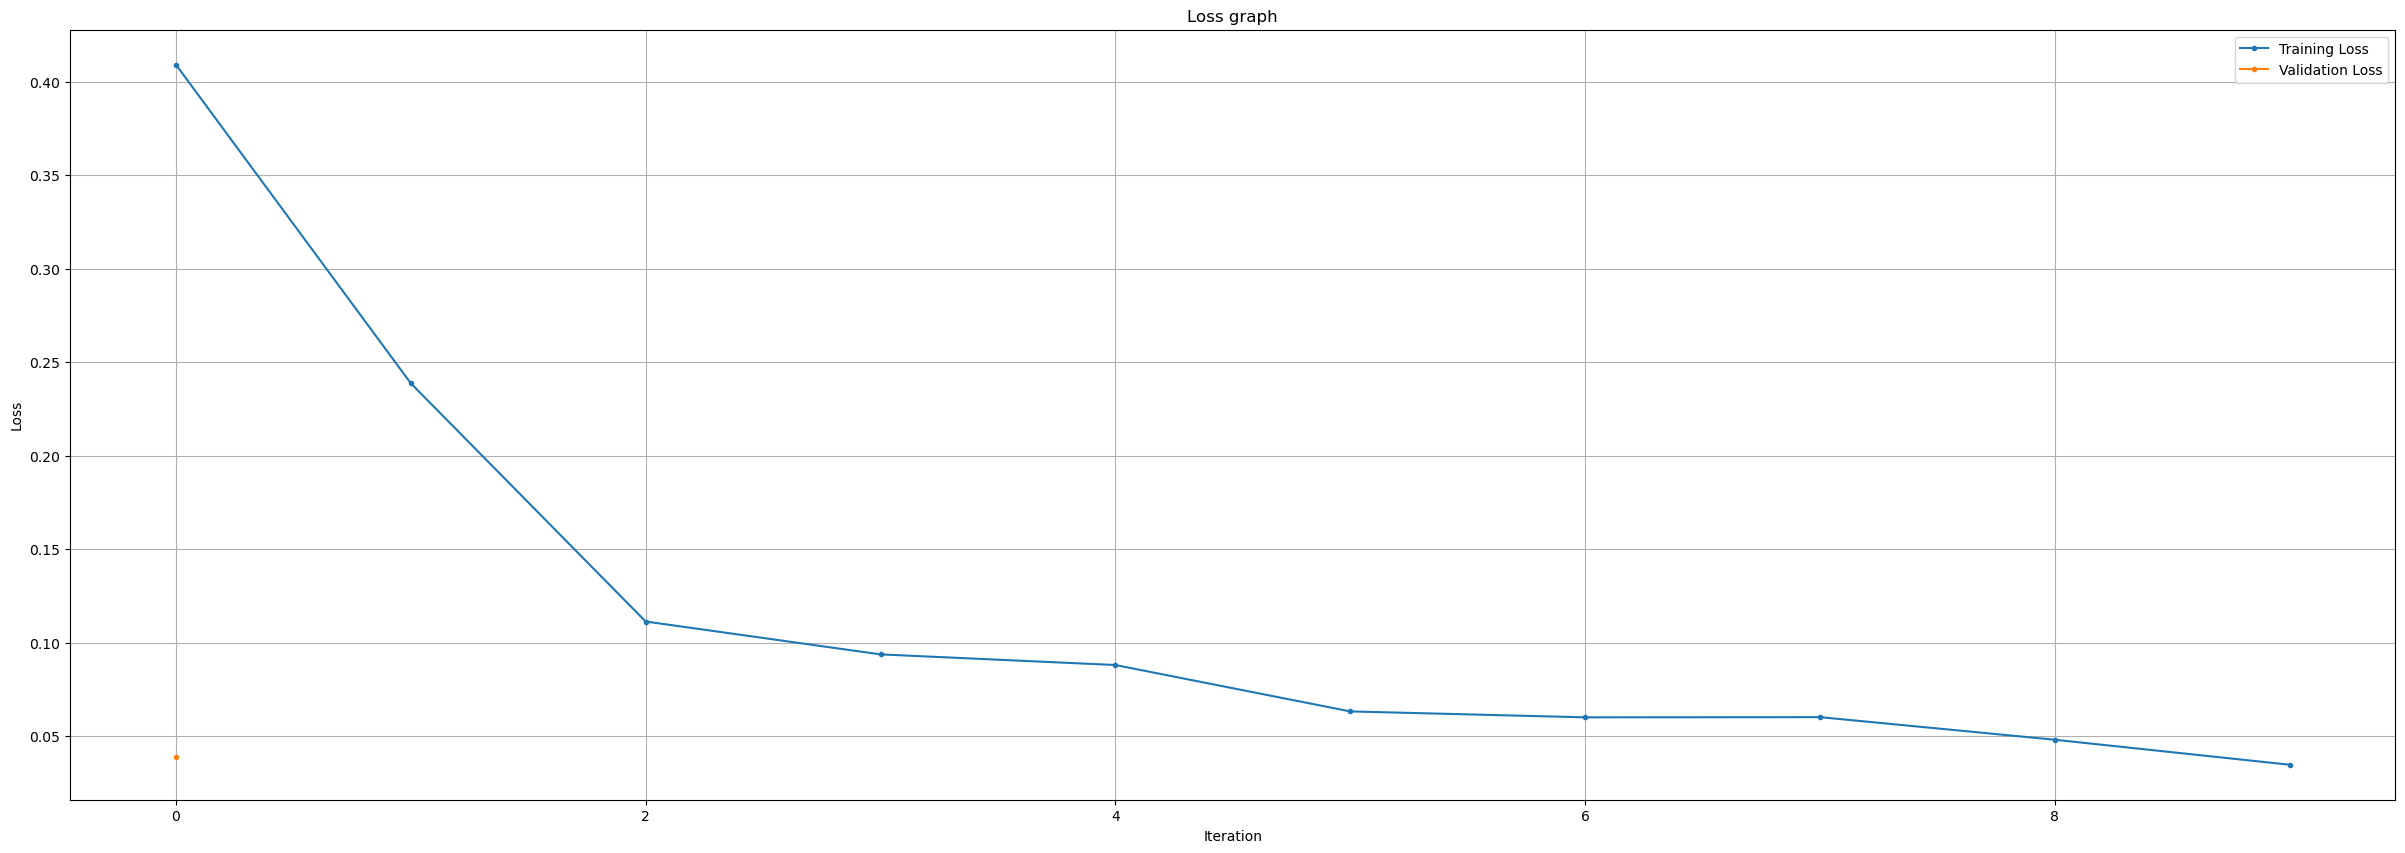

10 epoch now
11 epoch now
12 epoch now


KeyboardInterrupt: 

In [11]:
st_model.Train(
    train_X = train_X,
    train_y = train_y,
    val_X = val_X,
    val_y = val_y,
    num_of_epochs = 50,
    learning_rate = 1e-3,
    batch_size = 50,
    loss_func = torch.nn.MSELoss(),
    use_reg = False,
    reg_level = 2,
    optimizer = 1,
    is_sched_use = True,
    scheduler_freq = 200,
    scheduler_gamma = 0.5,
    val_every = 10,
    show_every = 10,
)

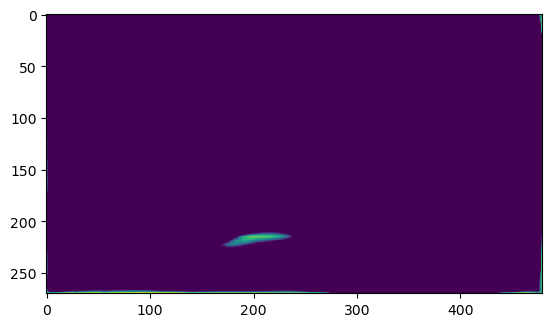

In [20]:
pred = st_model.Use(train_X[123].reshape((1, 3, 270, 480)))
ST.imshow(pred.resize(1, 270, 480))

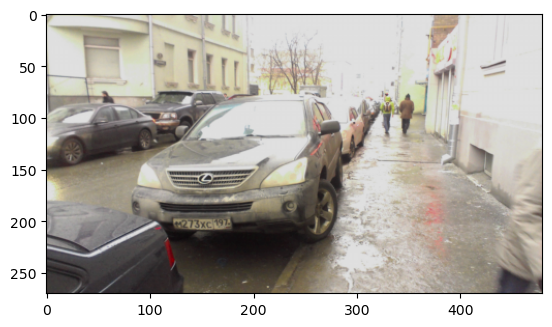

In [22]:
ST.imshow(train_X[123])